# SSAM: probabilistic cell labelling without segmentation

In [1]:
import tqdm as notebook_tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ssam

/data/leuven/338/vsc33850/miniconda3/envs/ssam/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [2]:
data = pd.read_csv("20220307_VIB_BartDeStrooper_MouseBrain_bin1_lasso.gem", delimiter = '\t')
data

,geneID,x,y,MIDCounts
0,0610005C13Rik,11271,7528,1
1,0610005C13Rik,9763,21366,1
2,0610005C13Rik,13474,13434,1
3,0610005C13Rik,15288,16152,1
4,0610005C13Rik,9727,9748,1
...,...,...,...,...
70013774,mt-Nd6,15156,11311,1
70013775,mt-Nd6,18046,10650,1
70013776,mt-Nd6,14677,19769,1
70013777,mt-Nd6,8884,8671,1


(5375.05, 20223.95, 5150.05, 24948.95)

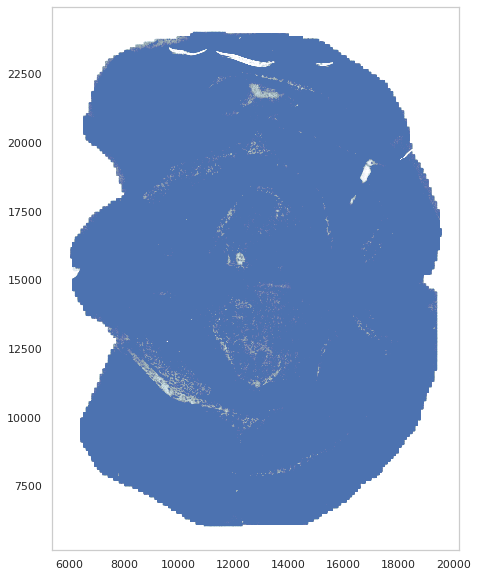

In [10]:
X = data.x
Y = data.y

plt.figure(figsize=(20,20))
plt.scatter(X,Y,s=0.00001)
plt.axis('scaled')

In [3]:
y_start = 13500
y_end = 14000
x_start= 8500
x_end = 9000

exp = data

sub_data = exp[(exp['x'] > x_start) & 
                       (exp['x'] < x_end) & 
                       (exp['y'] > y_start) & 
                       (exp['y'] < y_end)]

(8476.1, 9023.9, 13476.1, 14023.9)

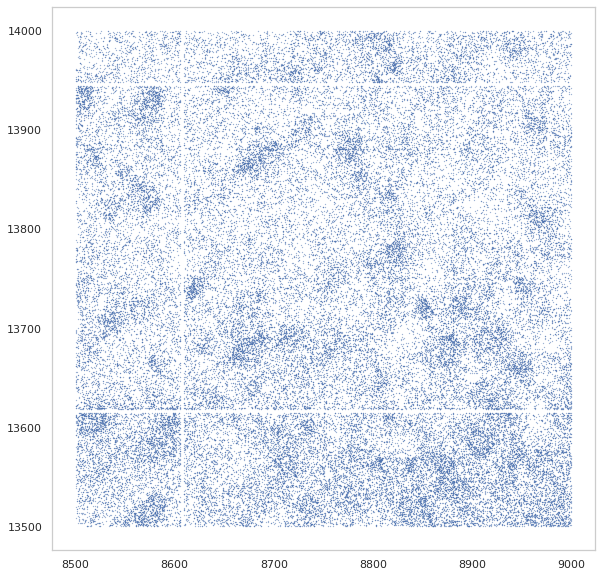

In [4]:
X = sub_data.x
Y = sub_data.y

plt.figure(figsize=(10,10))
plt.scatter(X,Y,s=0.05)
plt.axis('scaled')

In [4]:
def rescale(data):
    new_data = data.assign(x = data['x']-x_start, 
                y = data['y']-y_start)
    return new_data

exp = rescale(sub_data)
exp

,geneID,x,y,MIDCounts
775,0610009B22Rik,31,349,1
979,0610009B22Rik,271,400,1
1022,0610009B22Rik,269,122,2
1609,0610009B22Rik,354,21,1
1858,0610009B22Rik,183,389,1
...,...,...,...,...
70006695,mt-Nd6,257,452,1
70008413,mt-Nd6,26,350,1
70010907,mt-Nd6,222,429,2
70010908,mt-Nd6,221,91,1


In [5]:
exp = exp.loc[exp.index.repeat(exp.MIDCounts)] # we integrate info about number of transcript per nanoball for the same gene

In [6]:
width = exp.x.max() - exp.x.min() + 10
height = exp.y.max() - exp.y.min() + 10

In [7]:
exp = exp.drop("MIDCounts", axis=1)

In [8]:
exp.to_csv("coordinates_ssam.csv", index=False)

In [10]:
pd.read_csv("coordinates_ssam.csv")

,geneID,x,y
0,0610009B22Rik,31,349
1,0610009B22Rik,271,400
2,0610009B22Rik,269,122
3,0610009B22Rik,269,122
4,0610009B22Rik,354,21
...,...,...,...
99064,mt-Nd6,26,350
99065,mt-Nd6,222,429
99066,mt-Nd6,222,429
99067,mt-Nd6,221,91


In [8]:
data = exp

In [9]:
grouped = data.groupby('geneID').agg(list)
genes = list(grouped.index)

In [10]:
coord_list = []
for gene, coords in grouped.iterrows():
    coord_list.append(np.array(list(zip(*coords))))

In [11]:
ds = ssam.SSAMDataset(genes, coord_list, width, height)
ds

## Creating the vector field

After the data has been loaded, SSAM converts the discrete mRNA locations into mRNA density (that can be thought of as continuous “gene expression clouds” over the tissue) through application of Kernel Density Estimation.

### KDE

In [12]:
analysis = ssam.SSAMAnalysis(
  ds,
  ncores=20, # used for kde step
  save_dir="kde/",
  verbose=True)

In [13]:
# the most computationally expensive step

analysis.run_kde(bandwidth=1.5, use_mmap=False)

### Local maxima search and normalization

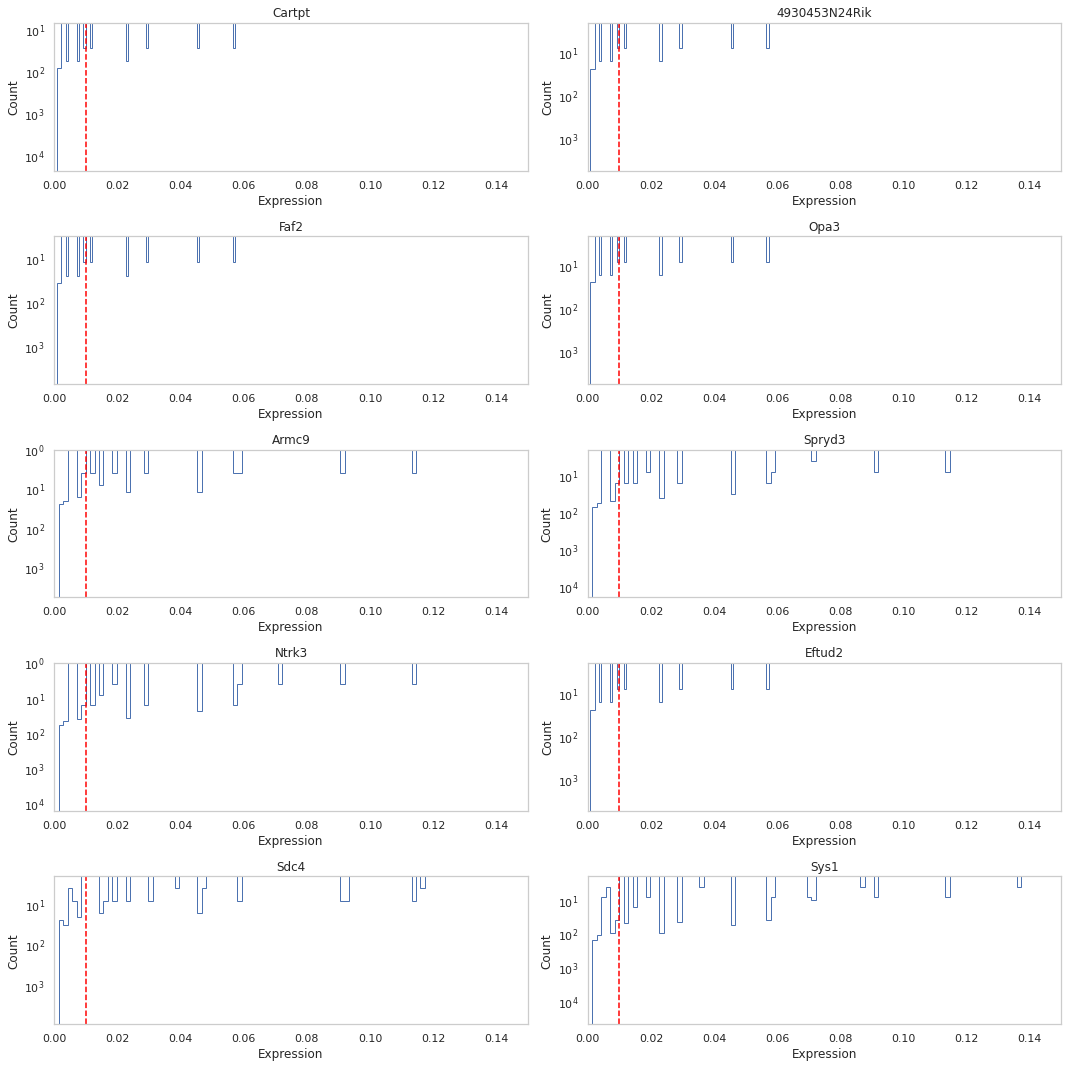

In [14]:
''' plot mean expression for random genes to understand threshold for local maxima'''
exp_thres = 0.01
viewport = 0.15
gindices = np.arange(len(ds.genes)) 
np.random.shuffle(gindices) 
plt.figure(figsize=[15, 15])
for i, gidx in enumerate(gindices[:10], start=1):
    ax = plt.subplot(5, 2, i)
    n, bins, patches = ax.hist(ds.vf[..., gidx][np.logical_and(ds.vf[..., gidx]> 0, ds.vf[..., gidx] < viewport)], bins=100, log=True, histtype=u'step')
    ax.set_xlim([0, viewport])
    ax.set_ylim([n[0], n[-1]])
    ax.axvline(exp_thres, c='red', ls='--')
    ax.set_title(ds.genes[gidx])
    ax.set_xlabel("Expression")
    ax.set_ylabel("Count")
plt.tight_layout() 
pass

In [162]:
np.max(n)

5870.0

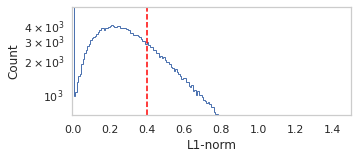

In [116]:
gidx = 0
norm_thres = 0.4
plt.figure(figsize=[5, 2])
#plt.hist(ds.vf[..., gidx][ds.vf[..., gidx] > 0], bins=100, log=True)
n, _, _ = plt.hist(ds.vf_norm[np.logical_and(ds.vf_norm > 0, ds.vf_norm < 0.8)], bins=100, log=True, histtype='step') 
ax = plt.gca()
ax.axvline(norm_thres, c='red', ls='--') 
ax.set_xlabel("L1-norm") 
ax.set_ylabel("Count")
plt.xlim([0, 1.5]) 
plt.ylim([np.min(n), np.max(n)])
#plt.ylim([n[0], n[-1]]) 
#pass
plt.savefig('SSAM-plots/l1_norm_stereoseq.png',
            facecolor ="white", dpi=150)

In [ ]:
analysis.find_localmax(
    search_size=1,
    min_norm=norm_thres, # the total gene expression threshold
    min_expression=exp_thres) # the per gene expression threshold

Found 96799 local max vectors.


In [ ]:
#parameters: 3, 0.6, 0.027

In [51]:
#analysis.expand_localmax(r=0.6)

Expanding local max vectors...
Processed 100/4409...
Processed 200/4409...
Processed 300/4409...
Processed 400/4409...
Processed 500/4409...
Processed 600/4409...
Processed 700/4409...
Processed 800/4409...
Processed 900/4409...
Processed 1000/4409...
Processed 1100/4409...
Processed 1200/4409...
Processed 1300/4409...
Processed 1400/4409...
Processed 1500/4409...
Processed 1600/4409...
Processed 1700/4409...
Processed 1800/4409...
Processed 1900/4409...
Processed 2000/4409...
Processed 2100/4409...
Processed 2200/4409...
Processed 2300/4409...
Processed 2400/4409...
Processed 2500/4409...
Processed 2600/4409...
Processed 2700/4409...
Processed 2800/4409...
Processed 2900/4409...
Processed 3000/4409...
Processed 3100/4409...
Processed 3200/4409...
Processed 3300/4409...
Processed 3400/4409...
Processed 3500/4409...
Processed 3600/4409...
Processed 3700/4409...
Processed 3800/4409...
Processed 3900/4409...
Processed 4000/4409...
Processed 4100/4409...
Processed 4200/4409...
Processed 43

In [ ]:
from sklearn.neighbors import KDTree
X = np.array([ds.local_maxs[0], ds.local_maxs[1]]).T 
kdt = KDTree(X, leaf_size=30, metric='euclidean')
rho = 100 / (np.pi * kdt.query(X, k=100)[0][:, 99] ** 2)

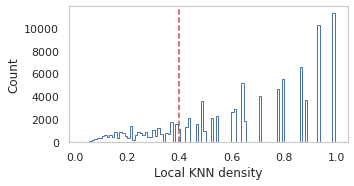

In [ ]:
threshold = 0.4#0.0125
plt.figure(figsize=[5, 2.5])
plt.hist(rho, bins=100, histtype='step')
plt.axvline(x=threshold, color='r', linestyle='--')

ax = plt.gca() 
ax.set_xlabel("Local KNN density") 
ax.set_ylabel("Count")
#pass
plt.savefig('SSAM-plots/knn_density_stereoseq2.png',
            facecolor ="white", dpi=150)

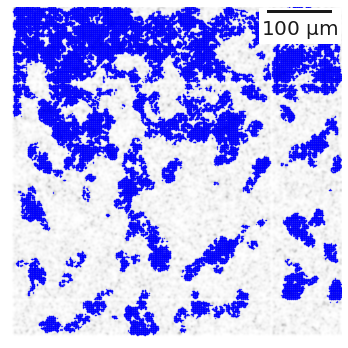

In [ ]:
mask = rho > threshold
plt.figure(figsize=[5, 10.3])
ds.plot_l1norm(cmap="Greys", rotate=1)
plt.scatter(ds.local_maxs[0][mask], ds.local_maxs[1][mask], c="blue", s=0.1)
from matplotlib_scalebar.scalebar import ScaleBar
scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20}) 
plt.gca().add_artist(scalebar)
plt.axis('off')
plt.tight_layout()
plt.xlim([ds.vf.shape[0], 0])
plt.ylim([ds.vf.shape[1], 0])
#plt.show()


plt.savefig('SSAM-plots/SSAM_stereo-seq_localmax2.png',
            facecolor ="white", dpi=150)

In [125]:
# apply mask
ds.local_maxs = tuple(ds.local_maxs[i][mask] for i in range(3))

In [126]:
analysis.normalize_vectors(use_expanded_vectors=False, normalize_gene=False,
                           normalize_vector=False, normalize_median=False,
                           size_after_normalization=10000.0,
                           log_transform=True, scale=False)#_sctransform()

## Clustering of expression vectors

In [127]:
import seaborn as sns
from sklearn import preprocessing 
import pickle

In [128]:
## Parameters for post-filtering of cell type maps
filter_method = "local"
filter_params = {
    "block_size": 151,
    "method": "mean",
    "mode": "constant",
    "offset": 0.3
}

In [129]:
analysis.cluster_vectors(
    min_cluster_size=10,
    pca_dims=33,
    resolution=0.15,
    centroid_correction_threshold=0.6,
    max_correlation=0.6,
    metric='correlation')

Found 126 clusters


## Cell type map

In [52]:
analysis.map_celltypes()
analysis.filter_celltypemaps(min_norm=filter_method,
                             filter_params=filter_params,
                             min_r=0.6, fill_blobs=True, min_blob_area=10)

In [53]:
len(ds.filtered_cluster_labels)

72885

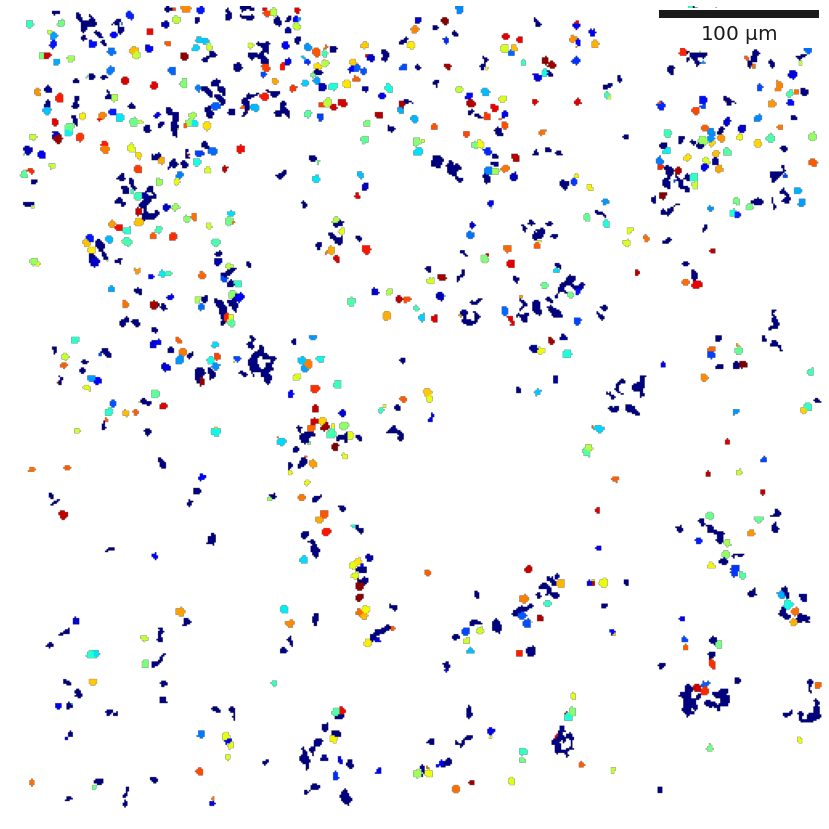

In [110]:
plt.figure(figsize=[15, 15]) 

ds.plot_celltypes_map(rotate=1, set_alpha=False,background='white')

scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20})
plt.gca().add_artist(scalebar)

plt.gca().get_xaxis().set_visible(False) 
plt.gca().get_yaxis().set_visible(False) 
sns.despine(top=True, bottom=True, left=True, right=True)


plt.savefig('SSAM-plots/SSAM_stereo-seq_celltypes-map2.png',
            facecolor ="white", dpi=150)
            

/data/leuven/338/vsc33850/miniconda3/envs/ssam/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


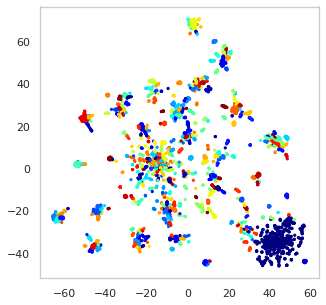

In [109]:
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=33,
             metric="correlation", s=5, run_tsne=True)
plt.savefig('SSAM-plots/tsne_stereo-seq2.png')

## Heatmap of annotated clusters

In [54]:
clusters= [
    "Astrocytes",
    "Oligodendrocytes",
    "Microglia",
    #"Neurons"
    "Vasculature",
    "Inhibitory neurons",
    "Excitatory neurons"
]

genes1 = [
    'Gad2',
    'Slc32a1',
    'Cnr1',
    'Vip',
    'Cpne5',
    'Crh',
    'Tbr1',
    'Rorb',
    'Kcnip2',
    'Aldoc',
    'Gfap',
    'Mfge8',
    'Sox10',
    'Plp1',
    'Pdgfra',
    'Itpr2',
    'Hexb',
    'Ttr',
    'Vtn',
    'Flt1',
]

genes = ["Aqp4", "Gfap", "Gja1", "Fgfr3", "Slc1a3", "Clu",
    "Mbp", "Plp1", "Pdgfra", "Mobp", 
    "Csf1r", "Tyrobp", "Itgam",
    "Syp","Cavin1",  "Cldn5", "Cd63",
    "Gad1", "Tac1","Gad2",
    "Camk2a",  "Syn1", "Cck"
]

In [100]:
heatmap_vectors = np.zeros([np.sum(ds.filtered_cluster_labels != -1), len(ds.genes)], dtype=float)
col_colors = np.zeros([np.sum(ds.filtered_cluster_labels != -1), 4]) 
genes_index = [ds.genes.index(g) for g in genes]

In [101]:
# Create labels-colors dictionares for plotting
import random

n_clusters = len(clusters)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(n_clusters)]

labels = {i for i in range(n_clusters)}

color_cluster = dict(zip(labels, colors))
color_cluster

{0: '#D01D39',
 1: '#E81D93',
 2: '#4E284B',
 3: '#FCFCF2',
 4: '#82EA64',
 5: '#68A7A8'}

In [102]:
from matplotlib.colors import to_rgba

acc_idx = 0
for cl_idx in range(0,len(clusters)):
    cl_vecs = ds.normalized_vectors[ds.filtered_cluster_labels == cl_idx]
    col = color_cluster[cl_idx]
    heatmap_vectors[acc_idx:acc_idx+cl_vecs.shape[0], :] = cl_vecs
    col_colors[acc_idx:acc_idx+cl_vecs.shape[0]] = to_rgba(col)
    acc_idx += cl_vecs.shape[0]
heatmap_vectors = heatmap_vectors[:, genes_index]

In [103]:
import seaborn as sns
gene_exp_heatmap = heatmap_vectors.T
gene_exp_heatmap = preprocessing.scale(gene_exp_heatmap) 

In [39]:
import sys
sys.setrecursionlimit(100000)

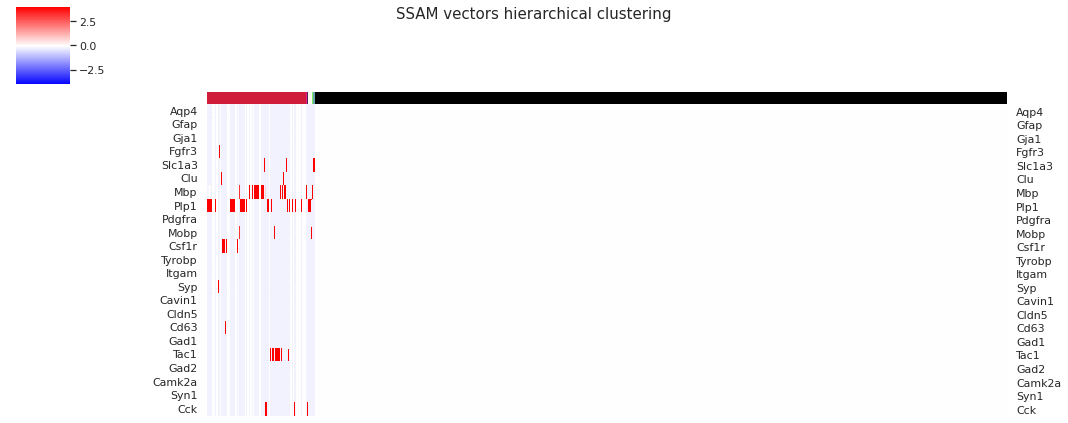

In [114]:
g = sns.clustermap(gene_exp_heatmap, figsize=[15, 6],
                   yticklabels=genes,
                   cmap='bwr', row_cluster=False, col_cluster=False,
                   col_colors=col_colors, xticklabels = False, 
                   vmin=-4, vmax=4, method = "average")
g.fig.suptitle("SSAM vectors hierarchical clustering", fontsize=15)
g.cax.set_visible(True)
g.ax_heatmap.tick_params(labelright=True, labelleft=True, right=False)
plt.savefig('SSAM-plots/heatmap_stereo-seq2.png')

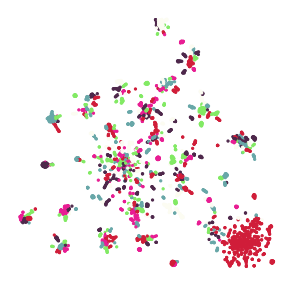

In [111]:
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False,
             colors=list(color_cluster.values())) 
plt.gca().get_xaxis().set_visible(False) 
plt.gca().get_yaxis().set_visible(False) 
plt.gca().axis('off')
plt.savefig('SSAM-plots/tsne_colored_stereo-seq2.png')

In [106]:
col_colors

array([[0.81568627, 0.11372549, 0.22352941, 1.        ],
       [0.81568627, 0.11372549, 0.22352941, 1.        ],
       [0.81568627, 0.11372549, 0.22352941, 1.        ],
       ...,
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

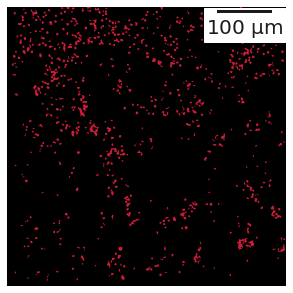

In [112]:
plt.figure(figsize=[5, 10.3]) 
ds.plot_celltypes_map(rotate=1, set_alpha=False, colors=col_colors)
scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False) 
plt.gca().get_yaxis().set_visible(False) 
sns.despine(top=True, bottom=True, left=True, right=True)
#plt.show()
plt.savefig('SSAM-plots/SSAM_stereo-seq_celltypes-colored.png',
            facecolor ="white", dpi=150)